15/10/2022

20BAI1042

A.M.Jhagan

CSE1016

Lab Assignment : 6

Object detection R-CNN

Here we have coded a R -CNN model using various functions so as to get an image as input and get the required object bounded in a bound- box as the output

Due to computational and storage restraints, here we build a "dog-detector" model

Importing necessary modules

In [1]:
#conda install keras

In [2]:
#pip install opencv-contrib-python

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, InputLayer, BatchNormalization, Dropout, Layer
from keras.layers import Input, Rescaling, ZeroPadding2D, RandomCrop, RandomFlip, AveragePooling2D, Flatten, Dense, Dropout

import pathlib
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import random
import numpy as np
import os
from glob import glob
from tqdm import tqdm
import requests
import cv2
from PIL import Image
from tensorflow import image

C:\Users\JHAGAN\anaconda3\envs\tf_gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


the groud truth function: for getting the bound boxes from the .xml files

In [51]:
def extract_ground_truth(path):

    
    boxes = []
    labels = []
    ids = []
    
    tree = ET.parse(path)
    id_i = path.split("/")[-1].split("_")[1]
    objects = tree.getroot().findall("object")

    for object_i in objects:
        object_name = object_i.find("name").text
        if object_name=="banana":  #apple, banana, orange
            instances = object_i.findall("bndbox")
            for instance in instances:
                xmin = int(float(instance.find("xmin").text))
                xmax = int(float(instance.find("xmax").text))
                ymin = int(float(instance.find("ymin").text))
                ymax = int(float(instance.find("ymax").text))
                box = np.array([xmin, xmax, ymin, ymax])
                boxes.append(box)
                labels.append(object_name)
                ids.append(id_i)    
        return np.array(boxes), np.array(labels), np.array(ids) #We will only consider last item, can be changed in future iterations

The regional proposal function

In [52]:
def region_proposals(image):
  
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    
    prediction_rects = _restructure_rectangles_xx(rects)
    return prediction_rects


Restructuring triangles to the image dimensions

In [53]:

def _restructure_rectangles_xx(old_rects):
    """Converts rectangles from (x, y, w, h) to (x1, x2, y1, y2)""" 
    x1 = old_rects[:,0]
    x2 = old_rects[:,2]+old_rects[:,0]
    y1 = old_rects[:,1]
    y2 = old_rects[:,1]+old_rects[:,3]

    rects_new = old_rects.copy()
    rects_new[:,0] = x1
    rects_new[:,1] = x2
    rects_new[:,2] = y1
    rects_new[:,3] = y2
    return rects_new


function to implement the above

In [54]:
def images_to_file(image, boxes, labels, predicted_rectangles, image_id, path="."):
    """Crops boxes and writes images to files."""
    
    if not os.path.exists(f"{path}/{labels[0]}"):
        os.makedirs(f"{path}/{labels[0]}")
    if not os.path.exists(f"{path}/no_category"):
        os.makedirs(f"{path}/no_category")        
    
    # Iterate through boxes
    for box, label, i_id in zip(boxes, labels, image_id):
        i_pos = i_neg = 0
        for rect in predicted_rectangles:  
            iou = _get_iou(box,rect)
            if iou > 0.5:
                i_pos +=1
                file_name = f"{path}/{label}/{i_id}_{i_pos}.jpg"
                cropped_image = image[rect[2]:rect[3], rect[0]:rect[1]]
                img = Image.fromarray(cropped_image, 'RGB')
                img2 = img.resize((227,227), Image.Resampling.LANCZOS)
                img2.save(file_name)
            elif iou < 0.1 and i_neg < 50:
                if (rect[3]-rect[2])>20 and (rect[1]-rect[0])>20: 
                    i_neg += 1
                    file_name = f"{path}/no_category/{label}_{i_id}_{i_neg}.jpg"
                    cropped_image = image[rect[2]:rect[3], rect[0]:rect[1]]
                    img = Image.fromarray(cropped_image, 'RGB')
                    img2 = img.resize((227,227), Image.Resampling.LANCZOS)
                    img2.save(file_name)


The intersection of union function

In [55]:
def _get_iou(bb1, bb2):
    
    assert bb1[0] < bb1[1]
    assert bb1[2] < bb1[3]
    assert bb2[0] < bb2[1]
    assert bb2[2] < bb2[3]
        # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[2], bb2[2])
    x_right = min(bb1[1], bb2[1])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[1] - bb1[0]) * (bb1[3] - bb1[2])
    bb2_area = (bb2[1] - bb2[0]) * (bb2[3] - bb2[2])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [56]:
metadata_paths = sorted(glob("Fruits/banana*.xml")) #apple, banana, orange
images_paths = sorted(glob("Fruits/banana*.jpg"))

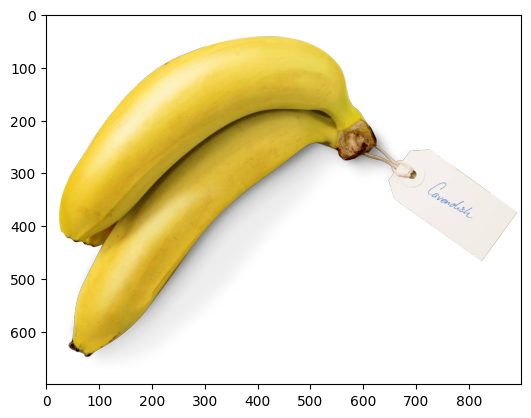

In [57]:
im = plt.imread("Fruits/banana_60.jpg")
plt.imshow(im)
plt.show()

In [58]:
for metadata_path, image_path in tqdm(zip(metadata_paths, images_paths)):
    if os.stat(image_path).st_size < 100000:
        image = cv2.imread(image_path)
        
        truth_recangles, truth_label, image_id = extract_ground_truth(metadata_path)
        if truth_label:
            
            predicted_rectangles = region_proposals(image)
            images_to_file(image, truth_recangles, truth_label, predicted_rectangles, image_id, "./training")

73it [05:59,  4.92s/it]


In [59]:
data_train = keras.utils.image_dataset_from_directory("./training", image_size=(227,227))

Found 7896 files belonging to 4 classes.


In [60]:
data_train.class_names

['apple', 'banana', 'no_category', 'orange']

Architecture of the model

In [64]:

class_weight = {0: 5, 1: 1}

input_l = keras.layers.Input(shape=(227, 227, 3))
input_layer = keras.layers.Rescaling(1./255)(input_l)
input_layer = keras.layers.ZeroPadding2D((16,16))(input_layer)
input_layer = keras.layers.RandomCrop(227,227)(input_layer)
input_layer = keras.layers.RandomFlip("horizontal")(input_layer)

headModel = keras.applications.MobileNetV2(weights="imagenet", include_top=False,input_tensor=input_layer)

for layer in headModel.layers:
    layer.trainable = False
    
headModel = headModel.output

baseModel = keras.layers.AveragePooling2D(pool_size=(7, 7))(headModel)
baseModel = keras.layers.Flatten(name="flatten")(baseModel)
baseModel = keras.layers.Dense(128, activation="relu")(baseModel)
baseModel = keras.layers.Dropout(0.3)(baseModel)
output = keras.layers.Dense(4, activation="softmax")(baseModel)


model = keras.models.Model(inputs=input_l, outputs=output)

In [65]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 227, 227, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 259, 259, 3)  0           rescaling_2[0][0]                
__________________________________________________________________________________________________
random_crop_2 (RandomCrop)      (None, 227, 227, 3)  0           zero_padding2d_2[0][0]           
____________________________________________________________________________________________

model compilation

In [66]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

history = model.fit(data_train, epochs=20, batch_size=64)
#, class_weight=class_weight

Epoch 1/20
247/247 [==============================] - 92s 342ms/step - loss: 0.1442 - accuracy: 0.9520
Epoch 2/20
247/247 [==============================] - 85s 343ms/step - loss: 0.0501 - accuracy: 0.9833
Epoch 3/20
247/247 [==============================] - 86s 346ms/step - loss: 0.0305 - accuracy: 0.9901
Epoch 4/20
247/247 [==============================] - 84s 341ms/step - loss: 0.0236 - accuracy: 0.9928
Epoch 5/20
247/247 [==============================] - 85s 342ms/step - loss: 0.0231 - accuracy: 0.9923
Epoch 6/20
247/247 [==============================] - 85s 342ms/step - loss: 0.0177 - accuracy: 0.9940
Epoch 7/20
247/247 [==============================] - 84s 340ms/step - loss: 0.0142 - accuracy: 0.9948
Epoch 8/20
247/247 [==============================] - 85s 343ms/step - loss: 0.0129 - accuracy: 0.9952
Epoch 9/20
247/247 [==============================] - 85s 343ms/step - loss: 0.0166 - accuracy: 0.9930
Epoch 10/20
247/247 [==============================] - 84s 340ms/step - l

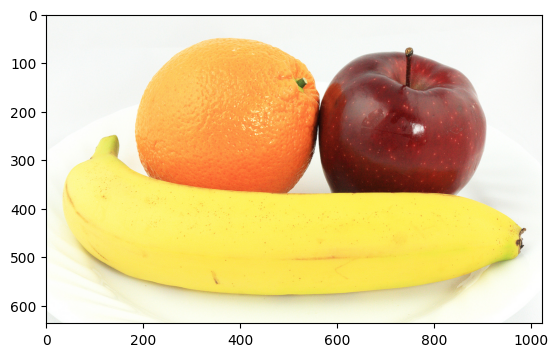

In [67]:
img = r"C:\Users\JHAGAN\Documents\Sem 5\CSE1016 DL\Lab\Programs\Object detection\mixed_fruits.jpg"
prediction = plt.imread(img)
plt.imshow(prediction)


### For predicting an image from internet

In [68]:
def images_to_file_prediction(image, predicted_rectangles, path="."):
    """Crops boxes and writes images to files."""

    if not os.path.exists(f"{path}/"):
        os.makedirs(f"{path}/")
 
    i_id = 0
    
    for predicted_rectangle in predicted_rectangles:
        file_name = f"{path}/{i_id}.jpg"
        cropped_image = image[predicted_rectangle[2]:predicted_rectangle[3], predicted_rectangle[0]:predicted_rectangle[1]]
        img = Image.fromarray(cropped_image, 'RGB')
        img2 = img.resize((227,227), Image.ANTIALIAS)
        img2.save(file_name)
        i_id +=1

In [69]:
predicton_rectangles = region_proposals(prediction)
images_to_file_prediction(prediction, predicton_rectangles, path="./prediction/pred")
prediction_data = keras.utils.image_dataset_from_directory("./prediction", image_size=(227,227), shuffle=False)

# Model prediction
prediction_output = model.predict(prediction_data, batch_size=1)

C:\Users\JHAGAN\AppData\Local\Temp\ipykernel_8096\1611274497.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img2 = img.resize((227,227), Image.ANTIALIAS)


Found 1301 files belonging to 1 classes.


In [70]:
def _restructure_rectangles_xy(old_rects):
    """Converts rectangles from (x, y, w, h) to (x1, y1, x2, y2)""" 
    x1 = old_rects[:,0]
    x2 = old_rects[:,1]
    y1 = old_rects[:,2]
    y2 = old_rects[:,3]

    rects_new = old_rects.copy()
    rects_new[:,1] = x1
    rects_new[:,0] = y1
    rects_new[:,3] = x2
    rects_new[:,2] = y2
    return rects_new

new_pred_rects = _restructure_rectangles_xy(predicton_rectangles)


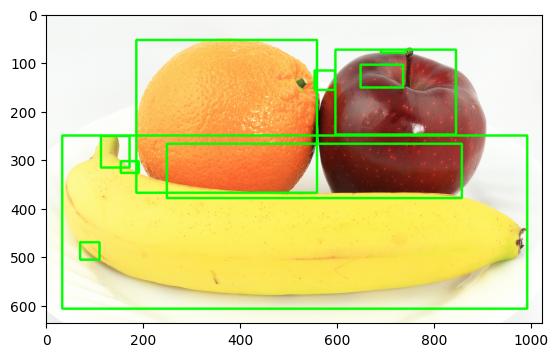

In [71]:

predictions = tf.image.non_max_suppression(new_pred_rects, prediction_output[:,0], max_output_size=10, iou_threshold=0.9)
image = plt.imread(img)

for ind_rect in predictions.numpy():
    #img_index = int(prediction_data.file_paths[ind_rect].split("/")[-1].split(".jpg")[0])
    
    rectangle_coordinates = predicton_rectangles[ind_rect].astype(int)
    rectangled_image = cv2.rectangle(image, (rectangle_coordinates[0], rectangle_coordinates[2]), (rectangle_coordinates[1], rectangle_coordinates[3]), (0, 255, 0), 3)
    plt.imshow(rectangled_image)

plt.show()

### Result

This is the final output, we see there are a lot of bounding boxes. Some of them are appropriately marked while some others might be mis-matched. This might be because of the model being so old and the training not done for more epochs


Link to drive: (For part 1,2,3)

https://drive.google.com/drive/folders/1ne8Isb9468I0gbo_dUmYq5gLQwniC6cw?usp=sharing